In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from collections import defaultdict

In [2]:
class digitRecognizer(nn.Module):
    def __init__(self):
        super(digitRecognizer, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = digitRecognizer()
model.load_state_dict(torch.load('nist_model2'))

<All keys matched successfully>

In [3]:
#preprocessing images of digits for better recognition
padding=9
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28-padding*2,28-padding*2)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
def process(image,x,y,w,h):
    threshold=0.95
    result = image[y:y+h, x:x+w]
    result=F.pad(transform(torch.from_numpy(result).unsqueeze(0)).squeeze(), (padding, padding, padding, padding), mode='constant',value=1.)
    result=F.threshold(result, threshold, 0)
    return result

In [46]:
def read(img):
    model.eval()
    model.double()
    if type(img)==str:
        image = cv2.imread(img)
    else:
        image=img
    plt.imshow(image)
    #grayscaling and threshold
    img_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_grey, 200, 255, cv2.THRESH_BINARY)
    #finding contours 
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    #removing contours that are not primary and removing the boundary of the whole image
    i=0
    while i<len(contours):
        if hierarchy[0][i][3]!=0 :
            contours=contours[:i]+contours[i+1:]
            hierarchy=np.array([np.delete(hierarchy[0],i,0)])
        else:
            i+=1
    #defining bounding boxes and centers for each digit
    rectangles=[]
    centers=[]
    for i in contours:
        rectangles.append(cv2.boundingRect(i))
    for (x,y,w,h) in rectangles:
        centers.append((x+(h+w)/2,y+(h+w)/2))
    #detecting bounding boxes that are too close using dbscan clustering to detect digits that are from the same multi-digit number
    nn=NearestNeighbors(2,radius=np.inf)
    nn.fit(np.array(centers))
    w_mean=np.array([np.abs(center[0]-centers[nn.kneighbors(np.array(center).reshape(1,-1))[1][0][1]][0]) for center in centers]).mean()
    dbscan = DBSCAN(eps=1.5*w_mean, min_samples=1)
    labels = dbscan.fit_predict(centers)
    #There are len(labels.unique()) numbers in the image
    nbr=len(set(labels))
    #a dictionnary with the x coordinate of each digit and its label to reconstitute the numbers in the correct order
    labels=dict(zip([rectangle[0] for rectangle in rectangles],labels))
    #dictionnary for predictions 
    preds={}
    #fill it with predictions
    for (x,y,w,h) in rectangles:
        to_analyse=process(img_grey,x,y,w,h)
        outputs=model(to_analyse.unsqueeze(0).double())
        _,predicted = torch.max(outputs.data, 1)
        preds[x]=predicted.item()
    # Use defaultdict to group keys by their values
    grouped_labels = defaultdict(list)
    for k, v in labels.items():
        grouped_labels[v].append(k)
    # Sort the keys within each group and print the results
    for v, keys in grouped_labels.items():
        keys_sorted = sorted(keys)
        for i in range (len(keys_sorted)):
            keys_sorted[i]=preds[keys_sorted[i]]
        grouped_labels[v]=''.join(map(str, keys_sorted))
    print('There are {} numbers in this image:'.format(nbr))
    for v, preds in grouped_labels.items():
        print(preds)
    return [int(preds) for v, preds in grouped_labels.items()]
        

There are 1 numbers in this image:
345


[345]

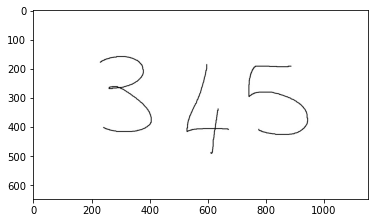

In [47]:
read('example1.jpg')

There are 2 numbers in this image:
34
72


[34, 72]

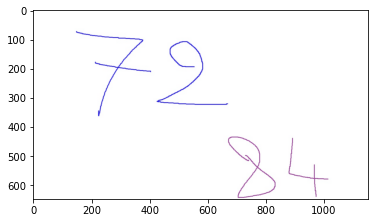

In [48]:
read('example2.jpg')

There are 4 numbers in this image:
87634
95
15
20


[87634, 95, 15, 20]

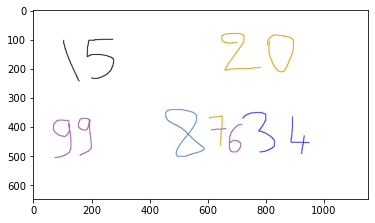

In [49]:
read('example3.jpg')